In [1]:
!pip install pytorch-metric-learning scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import os
import math
import collections
from pathlib import Path
from itertools import repeat
from types import FunctionType
from typing import Any, Callable, Optional, Tuple, Dict, Union
from collections.abc import Sequence
from collections import Counter 
from functools import partial
import warnings
import copy
import contextlib

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import pandas as pd
from PIL import Image

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
from torchvision import models
from torch.utils.data import ConcatDataset

from sklearn.model_selection import train_test_split

from pytorch_metric_learning import losses
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import CustomKNN
from pytorch_metric_learning.distances import CosineSimilarity

In [3]:
def _log_api_usage_once(obj: Any) -> None:
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")

def _make_ntuple(x: Any, n: int) -> tuple[Any, ...]:
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, n))

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)

    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [4]:
class SupConLoss(nn.Module):
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        if temperature <= 0:
            raise ValueError("temperature must be > 0")
        self.temperature = float(temperature)

    def forward(self, features: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        if features.dim() != 2:
            raise ValueError(f"features must be 2D (B, D), got {tuple(features.shape)}")
        if labels.dim() != 1:
            labels = labels.view(-1)

        device = features.device
        B = features.size(0)
        if B <= 1:
            return features.new_tensor(0.0)

        labels = labels.to(device)

        logits = (features @ features.T) / self.temperature

        logits = logits - logits.max(dim=1, keepdim=True).values.detach()

        matches = labels.unsqueeze(0).eq(labels.unsqueeze(1))
        self_mask = torch.eye(B, device=device, dtype=torch.bool)
        positives = matches & (~self_mask)

        # exp logits excluding self
        exp_logits = torch.exp(logits) * (~self_mask).float()
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)

        pos_counts = positives.sum(dim=1) 
        mean_log_prob_pos = torch.zeros(B, device=device, dtype=features.dtype)
        valid = pos_counts > 0
        if valid.any():
            mean_log_prob_pos[valid] = (log_prob[valid] * positives[valid].float()).sum(dim=1) / (
                pos_counts[valid].float() + 1e-12
            )

        loss = -mean_log_prob_pos[valid].mean() if valid.any() else features.new_tensor(0.0)
        return loss

In [5]:
interpolate = torch.nn.functional.interpolate
class FrozenBatchNorm2d(torch.nn.Module):
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
    ):
        super().__init__()
        _log_api_usage_once(self)
        self.eps = eps
        self.register_buffer("weight", torch.ones(num_features))
        self.register_buffer("bias", torch.zeros(num_features))
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def _load_from_state_dict(
        self,
        state_dict: dict,
        prefix: str,
        local_metadata: dict,
        strict: bool,
        missing_keys: list[str],
        unexpected_keys: list[str],
        error_msgs: list[str],
    ):
        num_batches_tracked_key = prefix + "num_batches_tracked"
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super()._load_from_state_dict(
            state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs
        )

    def forward(self, x: Tensor) -> Tensor:
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        scale = w * (rv + self.eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.weight.shape[0]}, eps={self.eps})"


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, tuple[int, ...]] = 3,
        stride: Union[int, tuple[int, ...]] = 1,
        padding: Optional[Union[int, tuple[int, ...], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, tuple[int, ...]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            if isinstance(kernel_size, int) and isinstance(dilation, int):
                padding = (kernel_size - 1) // 2 * dilation
            else:
                _conv_dim = len(kernel_size) if isinstance(kernel_size, Sequence) else len(dilation)
                kernel_size = _make_ntuple(kernel_size, _conv_dim)
                dilation = _make_ntuple(dilation, _conv_dim)
                padding = tuple((kernel_size[i] - 1) // 2 * dilation[i] for i in range(_conv_dim))
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        _log_api_usage_once(self)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )

class Conv2dNormActivation(ConvNormActivation):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, tuple[int, int]] = 3,
        stride: Union[int, tuple[int, int]] = 1,
        padding: Optional[Union[int, tuple[int, int], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, tuple[int, int]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv2d,
        )


class Conv3dNormActivation(ConvNormActivation):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, tuple[int, int, int]] = 3,
        stride: Union[int, tuple[int, int, int]] = 1,
        padding: Optional[Union[int, tuple[int, int, int], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm3d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, tuple[int, int, int]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv3d,
        )


class SqueezeExcitation(torch.nn.Module):
    def __init__(
        self,
        input_channels: int,
        squeeze_channels: int,
        activation: Callable[..., torch.nn.Module] = torch.nn.ReLU,
        scale_activation: Callable[..., torch.nn.Module] = torch.nn.Sigmoid,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc1 = torch.nn.Conv2d(input_channels, squeeze_channels, 1)
        self.fc2 = torch.nn.Conv2d(squeeze_channels, input_channels, 1)
        self.activation = activation()
        self.scale_activation = scale_activation()

    def _scale(self, input: Tensor) -> Tensor:
        scale = self.avgpool(input)
        scale = self.fc1(scale)
        scale = self.activation(scale)
        scale = self.fc2(scale)
        return self.scale_activation(scale)

    def forward(self, input: Tensor) -> Tensor:
        scale = self._scale(input)
        return scale * input


class MLP(torch.nn.Sequential):

    def __init__(
        self,
        in_channels: int,
        hidden_channels: list[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
    ):
        params = {} if inplace is None else {"inplace": inplace}

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(torch.nn.Linear(in_dim, hidden_dim, bias=bias))
            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer(**params))
            layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(in_dim, hidden_channels[-1], bias=bias))
        layers.append(torch.nn.Dropout(dropout, **params))

        super().__init__(*layers)
        _log_api_usage_once(self)


class Permute(torch.nn.Module):
    def __init__(self, dims: list[int]):
        super().__init__()
        self.dims = dims

    def forward(self, x: Tensor) -> Tensor:
        return torch.permute(x, self.dims)

In [6]:
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        with torch.cuda.amp.autocast(enabled=False):
            return self.gem(x.float(), p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        p_val = self.p.clamp(min=1.0, max=10.0)
            # Tăng eps lên một chút để tránh numerical issues
        eps_safe = max(eps, 1e-4)  # Tối thiểu 1e-4
        # Ensure x is positive and avoid numerical issues
        x_clamped = x.clamp(min=eps_safe)
        pooled = F.avg_pool2d(x_clamped.pow(p_val), (x.size(-2), x.size(-1)))
        
        return pooled.clamp(min=1e-6).pow(1.0 / p_val)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class HSVColorEncoder(nn.Module):
    def __init__(self, embedding_size: int = 64):
        super().__init__()
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.fc = nn.Linear(64 * 2, embedding_size)
        self.bn_fc = nn.BatchNorm1d(embedding_size)

    def rgb_to_hs(self, img):
        r, g, b = img[:, 0], img[:, 1], img[:, 2]
        
        max_c, _ = img.max(dim=1)
        min_c, _ = img.min(dim=1)
        diff = max_c - min_c + 1e-6  # Add epsilon to avoid division by zero
        
        s = torch.where(max_c == 0, torch.zeros_like(diff), diff / (max_c + 1e-6))
       
        mask_r = (max_c == r)
        mask_g = (max_c == g)
        mask_b = (max_c == b)
        
        h = torch.zeros_like(max_c)
        # Add epsilon to diff[mask_*] to avoid division by zero
        mask_r_valid = mask_r & (diff > 1e-6)
        mask_g_valid = mask_g & (diff > 1e-6)
        mask_b_valid = mask_b & (diff > 1e-6)
        
        h[mask_r_valid] = (g[mask_r_valid] - b[mask_r_valid]) / (diff[mask_r_valid] + 1e-8)
        h[mask_g_valid] = 2.0 + (b[mask_g_valid] - r[mask_g_valid]) / (diff[mask_g_valid] + 1e-8)
        h[mask_b_valid] = 4.0 + (r[mask_b_valid] - g[mask_b_valid]) / (diff[mask_b_valid] + 1e-8)
        
        h = (h / 6.0) % 1.0
        
        return torch.stack([h, s], dim=1)

    def forward(self, image_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406], device=image_tensor.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=image_tensor.device).view(1, 3, 1, 1)
        x = image_tensor * std + mean
        x = torch.clamp(x, 0, 1)
        
        x = self.rgb_to_hs(x) # (B, 2, H, W)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x))) 
        
        mean_feat = torch.mean(x, dim=[2, 3]) 
        std_feat = torch.std(x, dim=[2, 3]) 
        
        x = torch.cat([mean_feat, std_feat], dim=1)
        
        x = self.fc(x)
        x = self.bn_fc(x)
        
        return F.normalize(x, p=2, dim=1)

class AdaptiveSubCenterArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, base_m=0.5, k=3, class_counts=None):
        super().__init__()
        self.s = s
        self.base_s = s  # Lưu base scale để dùng trong warmup
        self.k = k 
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(out_features * k, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        if class_counts is not None:
            counts = torch.tensor(class_counts, dtype=torch.float32)
            # Ensure counts are positive and avoid division by zero
            counts = counts.clamp(min=1.0)
            m_list = base_m * (1.0 / torch.pow(counts, 0.25))
            # Normalize to base_m range, avoid division by zero
            m_min = m_list.min()
            if m_min > 1e-6:
                m_list = m_list / m_min * base_m
            else:
                m_list = torch.ones_like(m_list) * base_m
            self.register_buffer('m', m_list)
        else:
            self.register_buffer('m', torch.ones(out_features) * base_m)

    def forward(self, embedding, label):
        # Ensure label is tensor and in valid range
        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, device=embedding.device, dtype=torch.long)
        else:
            label = label.long()
        
        # Clamp labels to valid range
        label = torch.clamp(label, 0, self.out_features - 1)
        
        cosine = F.linear(F.normalize(embedding), F.normalize(self.weight))
        cosine = cosine.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine, dim=2)
        cosine = cosine.clamp(-1.0 + 1e-7, 1.0 - 1e-7)
        
        m_batch = self.m[label].view(-1, 1)
        
        # [FIX] Tính sine với numerical stability tốt hơn
        # Đảm bảo giá trị trong sqrt không âm và không quá nhỏ
        sine_sq = (1.0 - torch.pow(cosine, 2)).clamp(min=1e-7, max=1.0)
        sine = torch.sqrt(sine_sq)
        
        # Tính phi với numerical stability
        phi = cosine * torch.cos(m_batch) - sine * torch.sin(m_batch)
        
        # Hard margin condition
        threshold = torch.cos(math.pi - m_batch)
        phi = torch.where(cosine > threshold, phi, cosine - torch.sin(math.pi - m_batch) * m_batch)
        
        # [FIX] Clamp phi để tránh numerical issues trước khi nhân s
        phi = torch.clamp(phi, min=-1.0 + 1e-7, max=1.0 - 1e-7)
        
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # [FIX] Tính output trước, sau đó mới nhân s
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        
        # [FIX] Clamp output cuối cùng trước khi nhân s để tránh logits quá lớn
        # Logits quá lớn sẽ khiến Softmax (trong CrossEntropyLoss) bị tràn số
        output = torch.clamp(output, min=-1.0 + 1e-7, max=1.0 - 1e-7)
        
        # Kiểm tra NaN/Inf trước khi scale
        if not torch.isfinite(output).all():
            # Fallback: chỉ dùng cosine nếu có NaN
            output = torch.where(torch.isfinite(output), output, cosine)
        
        return output * self.s

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class InvertedResidualConfig:
    def __init__(
        self,
        input_channels: int,
        kernel: int,
        expanded_channels: int,
        out_channels: int,
        use_se: bool,
        activation: str,
        stride: int,
        dilation: int,
        width_mult: float,
    ):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):
    def __init__(
        self,
        cnf: InvertedResidualConfig,
        norm_layer: Callable[..., nn.Module],
        se_layer: Callable[..., nn.Module] = partial(SqueezeExcitation, scale_activation=nn.Hardsigmoid),
    ):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError("illegal stride value")

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: list[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        if cnf.expanded_channels != cnf.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cnf.input_channels,
                    cnf.expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels,
                cnf.expanded_channels,
                kernel_size=cnf.kernel,
                stride=stride,
                dilation=cnf.dilation,
                groups=cnf.expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )
        if cnf.use_se:
            squeeze_channels = _make_divisible(cnf.expanded_channels // 4, 8)
            layers.append(se_layer(cnf.expanded_channels, squeeze_channels))

        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer, activation_layer=None
            )
        )

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


def res_mobilenet_conf(
    width_mult: float = 1.0, reduced_tail: bool = False, **kwargs: Any
):
    reduce_divider = 2 if reduced_tail else 1
    
    bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    inverted_residual_setting = [
        bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
        bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  
        
        bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
        bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  
        bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
        bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
        
        bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  
        bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
        bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
        bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
        bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
        bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
        
        bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 1, 1),  
        bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, 2), 
        bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, 2), 
    ]
    
    last_channel = adjust_channels(1280 // reduce_divider)

    return inverted_residual_setting, last_channel


class ResMobileNetV2(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: list[InvertedResidualConfig],
        embedding_size: int,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        num_classes: int = 1000,
        use_attention: bool = False, 
        use_color_embedding: bool = True,
        color_embedding_size: int = 64,
        store_original_input: bool = True,  
        arcface_s : float = 30,
        class_counts: list = None,
        dropout_rate: float = 0.3,
        **kwargs: Any,
    ) -> None:
        super().__init__()

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        first_mobile_channels = inverted_residual_setting[0].input_channels
        if self.inplanes != first_mobile_channels:
            self.transition = nn.Sequential(
                conv1x1(self.inplanes, first_mobile_channels),
                norm_layer(first_mobile_channels),
            )
        else:
            self.transition = nn.Identity()

        layers: list[nn.Module] = []
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))
        self.mobile_features = nn.Sequential(*layers)

        input_channels = inverted_residual_setting[-1].out_channels
        bottleneck_planes = input_channels // 4

        self.res_block = Bottleneck(
            inplanes=input_channels,
            planes=bottleneck_planes,
            stride=1,
            downsample=None,
            norm_layer=norm_layer,
        )

        self.res_block_2 = Bottleneck(
            inplanes=input_channels,
            planes=bottleneck_planes,
            stride=1,
            downsample=None,
            norm_layer=norm_layer,
        )

        self.res_block_3 = Bottleneck(
            inplanes=input_channels,
            planes=bottleneck_planes,
            stride=1,
            downsample=None,
            norm_layer=norm_layer,
        )

        self.res_block_4 = Bottleneck(
            inplanes=input_channels,
            planes=bottleneck_planes,
            stride=1,
            downsample=None,
            norm_layer=norm_layer,
        )

        # self.res_block_5 = Bottleneck(
        #     inplanes=input_channels,
        #     planes=bottleneck_planes,
        #     stride=1,
        #     downsample=None,
        #     norm_layer=norm_layer,
        # )

        # self.res_block_6 = Bottleneck(
        #     inplanes=input_channels,
        #     planes=bottleneck_planes,
        #     stride=1,
        #     downsample=None,
        #     norm_layer=norm_layer,
        # )

        self.gem_pool = GeM(p=3.0) 
        self.color_encoder = HSVColorEncoder(embedding_size=color_embedding_size) if use_color_embedding else None
        self.arcface_head = AdaptiveSubCenterArcFace(embedding_size, num_classes, s=arcface_s, k=3, class_counts=class_counts)

        self.fc_1 = nn.Linear(input_channels, embedding_size)
        self.batch_norm_1 = nn.BatchNorm1d(embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def resnet_stem(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.transition(x)
        return x

    def get_mobile_features(self, x: Tensor) -> Tensor:
        return self.mobile_features(x)

    def resnet_tail(self, x: Tensor) -> Tensor:
        x = self.res_block(x)
        x = self.res_block_2(x)
        x = self.res_block_3(x)
        x = self.res_block_4(x)
        # x = self.res_block_5(x)
        # x = self.res_block_6(x)
        return x

    def forward(self, x: torch.Tensor, label=None, x_color=None):
        features = self.resnet_stem(x)
        features = self.get_mobile_features(features)
        features = self.resnet_tail(features)
        
        pooled = self.gem_pool(features)
        pooled = torch.flatten(pooled, 1)
        
        x_fc = self.dropout(self.batch_norm_1(self.fc_1(pooled)))
        visual_embedding = F.normalize(x_fc, p=2, dim=1)
        
        img_for_color = x_color if x_color is not None else x
        
        color_emb = self.color_encoder(img_for_color) if self.color_encoder else visual_embedding
        
        if self.training and label is not None:
            if not isinstance(label, torch.Tensor):
                label = torch.tensor(label, device=x.device, dtype=torch.long)
            
            logits = self.arcface_head(visual_embedding, label)
            return logits, visual_embedding, color_emb
        
        return visual_embedding, color_emb

@torch.no_grad()
def get_embeddings(model, data_loader, device):
    model.eval()
    visual_embeddings_list = []
    color_embeddings_list = []
    labels_list = []

    for images, labels in data_loader:
        images = images.to(device)

        visual_emb, color_emb = model(images)

        visual_embeddings_list.append(visual_emb.cpu())
        color_embeddings_list.append(color_emb.cpu())
        labels_list.append(labels.cpu())

    visual_embeddings_tensor = torch.cat(visual_embeddings_list, dim=0)
    color_embeddings_tensor = torch.cat(color_embeddings_list, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)

    return (visual_embeddings_tensor.numpy(), color_embeddings_tensor.numpy()), labels_tensor.numpy()

In [7]:
def pcgrad_backward_simple(
    loss_arc: torch.Tensor,
    loss_sup: torch.Tensor,
    shared_params: list,
    supcon_lambda: float = 1.0
) -> None:
    
    if loss_sup.item() == 0.0 or not loss_sup.requires_grad or loss_sup.grad_fn is None:

        loss_arc.backward()
        return

    for param in shared_params:
        if param.grad is not None:
            param.grad.zero_()
    loss_arc.backward(retain_graph=True)
    
    grads_arc = [param.grad.clone() if param.grad is not None else None for param in shared_params]
    
    for param in shared_params:
        if param.grad is not None:
            param.grad.zero_()
    (loss_sup * supcon_lambda).backward()
    
    grads_sup = [param.grad.clone() if param.grad is not None else None for param in shared_params]
    
    for i, param in enumerate(shared_params):
        g_arc = grads_arc[i]
        g_sup = grads_sup[i]
        
        if g_arc is None or g_sup is None:
            param.grad = g_arc if g_arc is not None else g_sup
            continue
            
        g_arc_flat = g_arc.flatten()
        g_sup_flat = g_sup.flatten()
        
        g_arc_unit = g_arc_flat / (torch.norm(g_arc_flat) + 1e-8)
        
        dot_product = torch.dot(g_arc_unit, g_sup_flat / (torch.norm(g_sup_flat) + 1e-8))
        
        if dot_product < 0:
            projection = torch.dot(g_sup_flat, g_arc_unit) * g_arc_unit
            g_sup_flat = g_sup_flat - projection
            
        param.grad = (g_arc_flat + g_sup_flat).view_as(param)

In [8]:
class VitroDataset(Dataset):
    def __init__(self, data_dir: str, transform_visual=None, transform_color=None, is_train=True):
        self.data_dir = Path(data_dir)
        self.transform_visual = transform_visual
        self.transform_color = transform_color
        self.is_train = is_train
        self.samples = []
        
        # Logic riêng Vitro: web/JPEG/*.jpg và web/PNG/*.png
        for class_dir in sorted(self.data_dir.iterdir()):
            if not class_dir.is_dir(): continue
            try:
                class_id = int(class_dir.name)
            except ValueError: continue
            
            web_dir = class_dir / "web"
            if web_dir.exists():
                # JPEG
                for img_file in sorted((web_dir / "JPEG").glob("*.jpg")) if (web_dir / "JPEG").exists() else []:
                    self.samples.append((str(img_file), class_id))
                # PNG
                for img_file in sorted((web_dir / "PNG").glob("*.png")) if (web_dir / "PNG").exists() else []:
                    self.samples.append((str(img_file), class_id))
        
        print(f" [Vitro] Loaded {len(self.samples)} samples from {len(set([s[1] for s in self.samples]))} classes")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.is_train:
            return (self.transform_visual(image), self.transform_color(image)), label - 1
        else:
            img = self.transform_color(image)
            return (img, img), label - 1

def freeze_layers(model: nn.Module, freeze_stem: bool = True, freeze_mobile: bool = False):
    """
    Freeze một số layer để train nhẹ hơn
    
    Args:
        freeze_stem: Freeze ResNet stem (conv1, bn1, maxpool, transition)
        freeze_mobile: Freeze MobileNet mid-blocks
    """
    if freeze_stem:
        for param in model.conv1.parameters():
            param.requires_grad = False
        for param in model.bn1.parameters():
            param.requires_grad = False
        for param in model.transition.parameters():
            param.requires_grad = False
        print("✅ Frozen: ResNet stem")
    
    if freeze_mobile:
        for param in model.mobile_features.parameters():
            param.requires_grad = False
        print("✅ Frozen: MobileNet mid-blocks")
    
    print("✅ Training: ResNet tail + Embedding head")


@torch.no_grad()
def compute_arcface_accuracy(embeddings, labels, arcface_head):
    """
    Precision@1 trên cosine thuần (không margin) để phản ánh retrieval.
    """
    cosine = F.linear(F.normalize(embeddings), F.normalize(arcface_head.weight))
    _, predicted = cosine.max(1)
    correct = predicted.eq(labels).sum().item()
    return correct

def train_epoch(model, train_loader, criterion, optimizer, device, epoch, use_amp=False):
    model.train()
    supcon_lambda = getattr(model, "supcon_lambda", 0.0)
    supcon_criterion = getattr(model, "supcon_criterion", None)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    
    for batch_data, labels in pbar:
        # [FIX] Unpack tuple ảnh từ Dataset
        # Dataset trả về: ((img_vis, img_col), label)
        if isinstance(batch_data, (list, tuple)):
            images_vis, images_col = batch_data
        else:
            images_vis = images_col = batch_data # Fallback nếu lỗi
            
        images_vis = images_vis.to(device, non_blocking=True) # Ảnh phá màu
        images_col = images_col.to(device, non_blocking=True) # Ảnh màu chuẩn
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            with torch.amp.autocast('cuda'):
                # [FIX] Truyền cả 2 loại ảnh vào model
                logits, visual_emb, color_emb = model(images_vis, labels, x_color=images_col)
                
                loss_arc = criterion(logits, labels)
                
                # SupCon học trên Color Embedding (từ ảnh màu chuẩn) -> Vẫn học được màu đúng!
                if supcon_lambda > 0 and supcon_criterion is not None:
                    loss_sup = supcon_criterion(color_emb, labels)
                else:
                    loss_sup = loss_arc.new_tensor(0.0)

                loss = loss_arc + (supcon_lambda * loss_sup)

            if not torch.isfinite(loss):
                optimizer.zero_grad()
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')):
                optimizer.zero_grad()
                continue 

             # --- BACKWARD ---
            scaler.scale(loss).backward()
            
            # [FIX] Unscale để tính norm
            scaler.unscale_(optimizer)
            
            # Clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # [FIX QUAN TRỌNG] Check Gradient NaN
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')):
                if epoch == 0 and total < 32:
                    print(f"   ⚠️  Skipping step (Grad NaN)")
                
                optimizer.zero_grad()
                # [BẮT BUỘC] Phải gọi update() để reset scaler state dù không step()
                scaler.update() 
                continue 
            
            scaler.step(optimizer)
            scaler.update()
        else:
            # FP32 Mode (Code tương tự)
            logits, visual_emb, color_emb = model(images_vis, labels, x_color=images_col)
            loss_arc = criterion(logits, labels)
            loss_sup = supcon_criterion(color_emb, labels) if (supcon_lambda > 0) else 0.0
            loss = loss_arc + (supcon_lambda * loss_sup)
            
            if not torch.isfinite(loss): continue
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')): continue
            optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
    epoch_acc = 100. * correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc

@torch.no_grad()
def validate(model, val_loader, criterion, device, epoch: int = 0, use_amp=False):
    """
    Validate model với cơ chế tính Accuracy có Margin y hệt lúc Train
    để theo dõi chính xác độ hội tụ trên tập Vitro/Situ.
    """
    model.eval()
    supcon_lambda = getattr(model, "supcon_lambda", 0.0)
    supcon_criterion = getattr(model, "supcon_criterion", None)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    
    for batch_data, labels in pbar:
        # 1. Unpack dữ liệu: Dataset trả về ((img_vis, img_col), label)
        if isinstance(batch_data, (list, tuple)):
            # Lúc Val ta dùng ảnh visual (vis) làm chuẩn cho cả 2 nhánh
            images_vis, images_col = batch_data
        else:
            images_vis = images_col = batch_data
            
        images_vis = images_vis.to(device, non_blocking=True)
        images_col = images_col.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # 2. Forward pass
        if use_amp:
            with torch.amp.autocast('cuda'):
                # Ở mode eval(), model trả về 2 giá trị: (visual_emb, color_emb)
                visual_emb, color_emb = model(images_vis)
                
                # [QUAN TRỌNG] Tự tính logits có margin để tính Acc giống Train
                logits = model.arcface_head(visual_emb, labels)
                
                # Tính Loss ArcFace
                loss_arc = criterion(logits, labels)
                
                # Tính Loss SupCon (nếu có)
                if supcon_lambda > 0 and supcon_criterion is not None:
                    loss_sup = supcon_criterion(color_emb, labels)
                else:
                    loss_sup = loss_arc.new_tensor(0.0)
                    
                loss = loss_arc + (supcon_lambda * loss_sup)
        else:
            # Mode FP32
            visual_emb, color_emb = model(images_vis)
            logits = model.arcface_head(visual_emb, labels)
            
            loss_arc = criterion(logits, labels)
            loss_sup = supcon_criterion(color_emb, labels) if supcon_lambda > 0 else 0.0
            loss = loss_arc + (supcon_lambda * loss_sup)

        # 3. Thống kê
        running_loss += loss.item()
        total += labels.size(0)
        
        # Accuracy tính bằng argmax của Logits (có Margin)
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    # Trả về trung bình loss và accuracy của epoch
    epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0.0
    epoch_acc = 100. * correct / total if total > 0 else 0.0
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def extract_embeddings(model, data_loader, device):
    model.eval()
    visual_embeddings = []
    labels = []
    
    for batch_data, batch_labels in tqdm(data_loader, desc="Extracting"):
        # [FIX] Handle tuple
        if isinstance(batch_data, (list, tuple)):
            images, _ = batch_data
        else:
            images = batch_data
            
        images = images.to(device)
        visual_emb, _ = model(images)
        visual_embeddings.append(visual_emb.cpu())
        labels.append(batch_labels)
    
    return torch.cat(visual_embeddings, dim=0).numpy(), torch.cat(labels, dim=0).numpy()

def compute_recall_at_k(test_emb, gallery_emb, test_labels, gallery_labels, k=5, device="cpu"):
    """Tính Recall@k"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Get top-k
    topk = torch.topk(similarity, k=k, dim=1).indices
    
    # Check if true label in top-k
    correct = 0
    for i in range(len(test_labels)):
        true_label = test_labels[i]
        retrieved_labels = gallery_labels[topk[i]]
        if (retrieved_labels == true_label).any():
            correct += 1
    
    recall = correct / len(test_labels)
    return recall


def compute_precision_at_1(test_emb, gallery_emb, test_labels, gallery_labels, device="cpu"):
    """Tính Precision@1 (1-NN Accuracy)"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Get top-1
    _, top1 = torch.topk(similarity, k=1, dim=1)
    top1 = top1.squeeze(1)
    
    # Check if predicted label matches true label
    predicted_labels = gallery_labels[top1]
    correct = (predicted_labels == test_labels).sum().item()
    precision = correct / len(test_labels)
    
    return precision


def compute_mean_average_precision(test_emb, gallery_emb, test_labels, gallery_labels, device="cpu"):
    """Tính Mean Average Precision (mAP)"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Sort by similarity
    _, indices = torch.sort(similarity, dim=1, descending=True)
    
    # Compute AP for each query
    aps = []
    for i in range(len(test_labels)):
        query_label = test_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        
        # Find relevant items (same label)
        relevant = (retrieved_labels == query_label).float()
        
        if relevant.sum() == 0:
            aps.append(0.0)
            continue
        
        # Compute precision at each relevant position
        cumulative_relevant = torch.cumsum(relevant, dim=0)
        precision_at_k = cumulative_relevant / torch.arange(1, len(relevant) + 1, dtype=torch.float32, device=device)
        
        # Average precision
        ap = (precision_at_k * relevant).sum() / relevant.sum()
        aps.append(ap.item())
    
    map_score = sum(aps) / len(aps)
    return map_score

def plot_training_curves(train_acc_history, val_acc_history, train_loss_history, val_loss_history, save_path=None):
    """
    Plot biểu đồ training curves: accuracy và loss
    Nếu save_path=None thì chỉ hiển thị, không lưu file
    """
    epochs = range(1, len(train_acc_history) + 1)
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Accuracy
    ax1.plot(epochs, train_acc_history, 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    # Highlight best validation accuracy
    if val_acc_history:
        best_val_acc = max(val_acc_history)
        best_epoch = val_acc_history.index(best_val_acc) + 1
        ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
        ax1.plot(best_epoch, best_val_acc, 'go', markersize=10, label=f'Best Val Acc: {best_val_acc:.2f}%')
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([1, len(epochs)])
    
    # Plot Loss
    ax2.plot(epochs, train_loss_history, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_loss_history, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([1, len(epochs)])
    
    plt.tight_layout()
    
    # Hiển thị biểu đồ thay vì lưu ảnh
    print(f"   📈 Training curves plotted successfully")
    print(f"   👁️  Đang hiển thị biểu đồ...")
    plt.show()


@torch.no_grad()
def evaluate_test(model, test_loader, train_loader, criterion, device):
    """Evaluate on test set với các metrics: Precision@1, Recall@5, mAP"""
    model.eval()
    
    print("\n🧪 Evaluating on TEST set...")
    print("   Extracting embeddings...")
    
    # Extract embeddings từ test set
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)
    
    # Extract embeddings từ train set (dùng làm gallery)
    gallery_embeddings, gallery_labels = extract_embeddings(model, train_loader, device)
    
    print("   Computing metrics...")
    
    # Compute metrics
    precision_at_1 = compute_precision_at_1(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, device=device
    )
    
    recall_at_5 = compute_recall_at_k(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, k=5, device=device
    )
    
    map_score = compute_mean_average_precision(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, device=device
    )
    
    # Print results
    print(f"\n📊 TEST Results:")
    print(f"   1-NN Accuracy (Precision@1): {precision_at_1 * 100:.2f}%")
    print(f"   Recall@5: {recall_at_5 * 100:.2f}%")
    print(f"   Mean Average Precision (mAP): {map_score:.4f}")
    
    return {
        'precision_at_1': precision_at_1,
        'recall_at_5': recall_at_5,
        'mean_average_precision': map_score,
        'test_embeddings': test_embeddings,
        'test_labels': test_labels,
        'gallery_embeddings': gallery_embeddings,
        'gallery_labels': gallery_labels
    }
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        # [FIX] Logic trả về 2 ảnh giống Situ
        if self.is_train:
            img_vis = self.transform_visual(image) if self.transform_visual else image
            img_col = self.transform_color(image) if self.transform_color else image
            label = label - 1
            return (img_vis, img_col), label
        else:
            img = self.transform_color(image) if self.transform_color else image
            label = label - 1
            return (img, img), label

In [9]:
class SituDataset(Dataset):
    def __init__(self, data_dir: str, transform_visual=None, transform_color=None, is_train=True):
        self.data_dir = Path(data_dir)
        # [FIX] Nhận đúng tham số transform
        self.transform_visual = transform_visual
        self.transform_color = transform_color
        self.is_train = is_train
        self.samples = []
        
        # Logic load ảnh Situ (Giữ nguyên)
        for class_dir in sorted(self.data_dir.iterdir()):
            if not class_dir.is_dir(): continue
            try:
                class_id = int(class_dir.name)
            except ValueError: continue
            
            video_dir = class_dir / "video"
            if video_dir.exists():
                for img_file in sorted(video_dir.glob("*.png")):
                    if img_file.name.lower() != "thumbs.db":
                        self.samples.append((str(img_file), class_id))
        
        print(f"   [Situ] Loaded {len(self.samples)} samples from {len(set([s[1] for s in self.samples]))} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.is_train:
            img_vis = self.transform_visual(image) if self.transform_visual else image
            img_col = self.transform_color(image) if self.transform_color else image
            label = label - 1
            return (img_vis, img_col), label
        else:
            img = self.transform_color(image) if self.transform_color else image
            label = label - 1
            return (img, img), label

def create_weighted_sampler(dataset):
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels)
    
    total_samples = len(labels)
    num_classes = len(class_counts)
    
    weights = []
    for _, label in dataset.samples:
        weight = total_samples / (num_classes * class_counts[label])
        weights.append(weight)
    
    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True
    )
    
    return sampler


def get_class_weights(dataset, num_classes=None, device='cpu'):
    """
    Tính class weights dựa trên inverse frequency
    
    Args:
        dataset: SituDataset
        num_classes: Số classes (nếu None thì dùng từ dataset)
        device: Device để tạo tensor
    
    Returns:
        Tensor class weights (size = num_classes, indices từ 0 đến num_classes-1)
    """
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels)
    
    total_samples = len(labels)
    dataset_num_classes = len(class_counts)

    if num_classes is None:
        num_classes = dataset_num_classes
    
    min_class_id = min(class_counts.keys())
    max_class_id = max(class_counts.keys())

    class_weights = torch.ones(num_classes, device=device)
    
    for class_id, count in class_counts.items():
        if 0 <= class_id < num_classes:
            weight = total_samples / (dataset_num_classes * count)
            class_weights[class_id] = weight
    
    print(f"   Dataset classes: {dataset_num_classes}, Model classes: {num_classes}")
    print(f"   Class weights shape: {class_weights.shape}")
    print(f"   Min class_id: {min_class_id}, Max class_id: {max_class_id}")
    
    return class_weights

def unfreeze_all_layers(model: nn.Module):
    for param in model.parameters():
        param.requires_grad = True
    print("✅ Unfrozen: All layers (full fine-tuning)")

@torch.no_grad()
def compute_arcface_accuracy(embeddings, labels, arcface_head):
    """
    Precision@1 trên cosine thuần (không margin) để phản ánh retrieval.
    """
    cosine = F.linear(F.normalize(embeddings), F.normalize(arcface_head.weight))
    _, predicted = cosine.max(1)
    correct = predicted.eq(labels).sum().item()
    return correct


def load_pretrained_checkpoint(model: nn.Module, checkpoint_path: str, device: str, strict: bool = False):

    print(f"📂 Loading pretrained checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    state_dict = checkpoint['model_state_dict']
    model_state_dict = model.state_dict()
    
    if not strict:
        # Handle ArcFace head weight shape mismatch
        # [FIX] AdaptiveSubCenterArcFace có weight shape (out_features * k, in_features)
        if 'arcface_head.weight' in state_dict:
            pretrained_weight = state_dict['arcface_head.weight']
            current_weight = model_state_dict['arcface_head.weight']
            
            # Tính num_classes từ weight shape (weight shape = num_classes * k)
            # Giả sử k=3 (default của AdaptiveSubCenterArcFace)
            pretrained_k = 3  # Có thể detect từ checkpoint nếu cần
            current_k = getattr(model.arcface_head, 'k', 3)
            
            pretrained_num_classes = pretrained_weight.shape[0] // pretrained_k
            current_num_classes = current_weight.shape[0] // current_k
            
            if pretrained_num_classes != current_num_classes:
                print(f"   ⚠️  num_classes mismatch: {pretrained_num_classes} vs {current_num_classes}")
                print(f"   ⚠️  Skipping arcface_head.weight and arcface_head.m, will initialize randomly")
                state_dict.pop('arcface_head.weight', None)
                # Cũng skip margin buffer nếu có
                if 'arcface_head.m' in state_dict:
                    state_dict.pop('arcface_head.m', None)
    
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
    
    # [FIX] Kiểm tra xem ArcFace head có load được không
    arcface_not_loaded = 'arcface_head.weight' in missing_keys or 'arcface_head.m' in missing_keys
    
    if missing_keys:
        print(f"   ⚠️  Missing keys (will use random init): {len(missing_keys)}")
        for key in missing_keys[:5]:
            print(f"      - {key}")
        if len(missing_keys) > 5:
            print(f"      ... and {len(missing_keys) - 5} more")
    
    if unexpected_keys:
        print(f"   ⚠️  Unexpected keys (ignored): {len(unexpected_keys)}")
    
    print(f"   ✅ Loaded pretrained weights from epoch {checkpoint.get('epoch', '?')}")
    print(f"   ✅ Pretrained val acc: {checkpoint.get('val_acc', 0):.2f}%")
    

def train_epoch(model, train_loader, criterion, optimizer, device, epoch, use_amp=False):
    model.train()
    supcon_lambda = getattr(model, "supcon_lambda", 0.0)
    supcon_criterion = getattr(model, "supcon_criterion", None)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    
    for batch_data, labels in pbar:
        # [FIX] Unpack tuple ảnh từ Dataset
        # Dataset trả về: ((img_vis, img_col), label)
        if isinstance(batch_data, (list, tuple)):
            images_vis, images_col = batch_data
        else:
            images_vis = images_col = batch_data # Fallback nếu lỗi
            
        images_vis = images_vis.to(device, non_blocking=True) # Ảnh phá màu
        images_col = images_col.to(device, non_blocking=True) # Ảnh màu chuẩn
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            with torch.amp.autocast('cuda'):
                # [FIX] Truyền cả 2 loại ảnh vào model
                logits, visual_emb, color_emb = model(images_vis, labels, x_color=images_col)
                
                loss_arc = criterion(logits, labels)
                
                # SupCon học trên Color Embedding (từ ảnh màu chuẩn) -> Vẫn học được màu đúng!
                if supcon_lambda > 0 and supcon_criterion is not None:
                    loss_sup = supcon_criterion(color_emb, labels)
                else:
                    loss_sup = loss_arc.new_tensor(0.0)

                loss = loss_arc + (supcon_lambda * loss_sup)

            if not torch.isfinite(loss):
                optimizer.zero_grad()
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')):
                optimizer.zero_grad()
                continue 

             # --- BACKWARD ---
            scaler.scale(loss).backward()
            
            # [FIX] Unscale để tính norm
            scaler.unscale_(optimizer)
            
            # Clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # [FIX QUAN TRỌNG] Check Gradient NaN
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')):
                if epoch == 0 and total < 32:
                    print(f"   ⚠️  Skipping step (Grad NaN)")
                
                optimizer.zero_grad()
                # [BẮT BUỘC] Phải gọi update() để reset scaler state dù không step()
                scaler.update() 
                continue 
            
            scaler.step(optimizer)
            scaler.update()
        else:
            # FP32 Mode (Code tương tự)
            logits, visual_emb, color_emb = model(images_vis, labels, x_color=images_col)
            loss_arc = criterion(logits, labels)
            loss_sup = supcon_criterion(color_emb, labels) if (supcon_lambda > 0) else 0.0
            loss = loss_arc + (supcon_lambda * loss_sup)
            
            if not torch.isfinite(loss): continue
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if not torch.isfinite(torch.tensor(grad_norm, device='cpu')): continue
            optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
    epoch_acc = 100. * correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc

@torch.no_grad()
def validate(model, val_loader, criterion, device, epoch: int = 0, use_amp=False):
    """
    Validate model với cơ chế tính Accuracy có Margin y hệt lúc Train
    để theo dõi chính xác độ hội tụ trên tập Vitro/Situ.
    """
    model.eval()
    supcon_lambda = getattr(model, "supcon_lambda", 0.0)
    supcon_criterion = getattr(model, "supcon_criterion", None)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    
    for batch_data, labels in pbar:
        # 1. Unpack dữ liệu: Dataset trả về ((img_vis, img_col), label)
        if isinstance(batch_data, (list, tuple)):
            # Lúc Val ta dùng ảnh visual (vis) làm chuẩn cho cả 2 nhánh
            images_vis, images_col = batch_data
        else:
            images_vis = images_col = batch_data
            
        images_vis = images_vis.to(device, non_blocking=True)
        images_col = images_col.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # 2. Forward pass
        if use_amp:
            with torch.amp.autocast('cuda'):
                # Ở mode eval(), model trả về 2 giá trị: (visual_emb, color_emb)
                visual_emb, color_emb = model(images_vis)
                
                # [QUAN TRỌNG] Tự tính logits có margin để tính Acc giống Train
                logits = model.arcface_head(visual_emb, labels)
                
                # Tính Loss ArcFace
                loss_arc = criterion(logits, labels)
                
                # Tính Loss SupCon (nếu có)
                if supcon_lambda > 0 and supcon_criterion is not None:
                    loss_sup = supcon_criterion(color_emb, labels)
                else:
                    loss_sup = loss_arc.new_tensor(0.0)
                    
                loss = loss_arc + (supcon_lambda * loss_sup)
        else:
            # Mode FP32
            visual_emb, color_emb = model(images_vis)
            logits = model.arcface_head(visual_emb, labels)
            
            loss_arc = criterion(logits, labels)
            loss_sup = supcon_criterion(color_emb, labels) if supcon_lambda > 0 else 0.0
            loss = loss_arc + (supcon_lambda * loss_sup)

        # 3. Thống kê
        running_loss += loss.item()
        total += labels.size(0)
        
        # Accuracy tính bằng argmax của Logits (có Margin)
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    # Trả về trung bình loss và accuracy của epoch
    epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0.0
    epoch_acc = 100. * correct / total if total > 0 else 0.0
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def extract_embeddings(model, data_loader, device):
    model.eval()
    visual_embeddings = []
    labels = []
    
    for batch_data, batch_labels in tqdm(data_loader, desc="Extracting"):
        # [FIX] Handle tuple
        if isinstance(batch_data, (list, tuple)):
            images, _ = batch_data
        else:
            images = batch_data
            
        images = images.to(device)
        visual_emb, _ = model(images)
        visual_embeddings.append(visual_emb.cpu())
        labels.append(batch_labels)
    
    return torch.cat(visual_embeddings, dim=0).numpy(), torch.cat(labels, dim=0).numpy()


def compute_recall_at_k(test_emb, gallery_emb, test_labels, gallery_labels, k=5, device="cpu"):
    """Tính Recall@k"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Get top-k
    topk = torch.topk(similarity, k=k, dim=1).indices
    
    # Check if true label in top-k
    correct = 0
    for i in range(len(test_labels)):
        true_label = test_labels[i]
        retrieved_labels = gallery_labels[topk[i]]
        if (retrieved_labels == true_label).any():
            correct += 1
    
    recall = correct / len(test_labels)
    return recall


def compute_precision_at_1(test_emb, gallery_emb, test_labels, gallery_labels, device="cpu"):
    """Tính Precision@1 (1-NN Accuracy)"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Get top-1
    _, top1 = torch.topk(similarity, k=1, dim=1)
    top1 = top1.squeeze(1)
    
    # Check if predicted label matches true label
    predicted_labels = gallery_labels[top1]
    correct = (predicted_labels == test_labels).sum().item()
    precision = correct / len(test_labels)
    
    return precision


def compute_mean_average_precision(test_emb, gallery_emb, test_labels, gallery_labels, device="cpu"):
    """Tính Mean Average Precision (mAP)"""
    test_emb = torch.tensor(test_emb, dtype=torch.float32, device=device)
    gallery_emb = torch.tensor(gallery_emb, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, device=device)
    gallery_labels = torch.tensor(gallery_labels, device=device)
    
    # Normalize embeddings
    test_emb = torch.nn.functional.normalize(test_emb, p=2, dim=1)
    gallery_emb = torch.nn.functional.normalize(gallery_emb, p=2, dim=1)
    
    # Compute similarity
    similarity = test_emb @ gallery_emb.T
    
    # Sort by similarity
    _, indices = torch.sort(similarity, dim=1, descending=True)
    
    # Compute AP for each query
    aps = []
    for i in range(len(test_labels)):
        query_label = test_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        
        # Find relevant items (same label)
        relevant = (retrieved_labels == query_label).float()
        
        if relevant.sum() == 0:
            aps.append(0.0)
            continue
        
        # Compute precision at each relevant position
        cumulative_relevant = torch.cumsum(relevant, dim=0)
        precision_at_k = cumulative_relevant / torch.arange(1, len(relevant) + 1, dtype=torch.float32, device=device)
        
        # Average precision
        ap = (precision_at_k * relevant).sum() / relevant.sum()
        aps.append(ap.item())
    
    map_score = sum(aps) / len(aps)
    return map_score


def plot_training_curves(train_acc_history, val_acc_history, train_loss_history, val_loss_history, save_path=None):
    """
    Plot biểu đồ training curves: accuracy và loss
    Nếu save_path=None thì chỉ hiển thị, không lưu file
    """
    epochs = range(1, len(train_acc_history) + 1)
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Accuracy
    ax1.plot(epochs, train_acc_history, 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    # Highlight best validation accuracy
    if val_acc_history:
        best_val_acc = max(val_acc_history)
        best_epoch = val_acc_history.index(best_val_acc) + 1
        ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
        ax1.plot(best_epoch, best_val_acc, 'go', markersize=10, label=f'Best Val Acc: {best_val_acc:.2f}%')
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([1, len(epochs)])
    
    # Plot Loss
    ax2.plot(epochs, train_loss_history, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_loss_history, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([1, len(epochs)])
    
    plt.tight_layout()
    
    # Hiển thị biểu đồ thay vì lưu ảnh
    print(f"   📈 Training curves plotted successfully")
    print(f"   👁️  Đang hiển thị biểu đồ...")
    plt.show()


@torch.no_grad()
def evaluate_test(model, test_loader, train_loader, criterion, device):
    """Evaluate on test set với các metrics: Precision@1, Recall@5, mAP"""
    model.eval()
    
    print("\n🧪 Evaluating on TEST set...")
    print("   Extracting embeddings...")
    
    # Extract embeddings từ test set
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)
    
    # Extract embeddings từ train set (dùng làm gallery)
    gallery_embeddings, gallery_labels = extract_embeddings(model, train_loader, device)
    
    print("   Computing metrics...")
    
    # Compute metrics
    precision_at_1 = compute_precision_at_1(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, device=device
    )
    
    recall_at_5 = compute_recall_at_k(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, k=5, device=device
    )
    
    map_score = compute_mean_average_precision(
        test_embeddings, gallery_embeddings, test_labels, gallery_labels, device=device
    )
    
    # Print results
    print(f"\n📊 TEST Results:")
    print(f"   1-NN Accuracy (Precision@1): {precision_at_1 * 100:.2f}%")
    print(f"   Recall@5: {recall_at_5 * 100:.2f}%")
    print(f"   Mean Average Precision (mAP): {map_score:.4f}")
    
    return {
        'precision_at_1': precision_at_1,
        'recall_at_5': recall_at_5,
        'mean_average_precision': map_score,
        'test_embeddings': test_embeddings,
        'test_labels': test_labels,
        'gallery_embeddings': gallery_embeddings,
        'gallery_labels': gallery_labels
    }

In [10]:
def create_data_loaders(
    data_dir: str,
    batch_size: int = 32,
    num_workers: int = 8, 
    train_split: float = 0.7,
    val_split: float = 0.10,
    test_split: float = 0.20,
    use_weighted_sampling: bool = True,
    dataset_type: str = 'situ' 
):
    if dataset_type == 'situ':
        transform_visual_train = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            # --- Augmentation màu mạnh ---
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1)
        ])
    else:
        transform_visual_train = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1)
        ])
    
    # 2. Transform chuẩn cho Color (Train) và All (Val/Test)
    transform_clean = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # Val/Test dùng CenterCrop
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform chuẩn cho Color branch lúc Train (Có thể RandomCrop nhẹ)
    transform_color_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Chọn class Dataset
    DatasetClass = SituDataset if dataset_type.lower() == 'situ' else VitroDataset
    full_dataset = SituDataset(data_dir, transform_visual=transform_visual_train)

    # [FIX QUAN TRỌNG] Tạo 2 dataset riêng biệt để tránh lỗi reference
    # Dataset 1: Dùng cho Train (is_train=True)
    full_train_dataset = DatasetClass(
        data_dir, 
        transform_visual=transform_visual_train, 
        transform_color=transform_color_train, 
        is_train=True
    )
    
    # Dataset 2: Dùng cho Val/Test (is_train=False)
    full_val_dataset = DatasetClass(
        data_dir, 
        transform_visual=None, 
        transform_color=transform_clean, 
        is_train=False
    )
    
    # Tính toán indices để split
    total_size = len(full_train_dataset)
    train_size = int(total_size * train_split)
    val_size = int(total_size * val_split)
    test_size = total_size - train_size - val_size
    
    # Tạo indices ngẫu nhiên
    indices = torch.randperm(total_size).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Tạo Subset từ đúng dataset nguồn
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)   # Lấy từ dataset Val
    test_dataset = Subset(full_val_dataset, test_indices) # Lấy từ dataset Val
    
    # Weighted Sampler logic
    if use_weighted_sampling:
        # Lấy label từ full_train_dataset thông qua indices
        train_labels = [full_train_dataset.samples[i][1] for i in train_indices]
        class_counts = Counter(train_labels)
        
        weights = []
        for i in train_indices:
            label = full_train_dataset.samples[i][1]
            # Tránh chia cho 0 nếu count lỗi
            count = class_counts[label] if class_counts[label] > 0 else 1
            weights.append(1.0 / count)
            
        train_sampler = WeightedRandomSampler(weights, len(weights))
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                  num_workers=num_workers, pin_memory=True, persistent_workers=False)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=num_workers, pin_memory=True, persistent_workers=False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True, persistent_workers=False)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers, pin_memory=True, persistent_workers=False)
    
    raw_ids = [cid for _, cid in full_train_dataset.samples] 
    max_label = max(raw_ids) - 1                        
    num_classes = int(max_label + 1)
    return train_loader, val_loader, test_loader, num_classes, full_dataset

In [11]:
data_dir = '/kaggle/input/dataxuly/processing/vitro'  
output_dir = '/kaggle/working/checkpoints/vitro'
epochs = 20
batch_size = 64
lr = 0.001
embedding_size = 512
use_color_embedding = True
color_embedding_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
freeze_stem = True
freeze_mobile = False
arcface_scale = 64
arcface_margin = 0.3
arcface_margin_warmup_epochs = 0

os.makedirs(output_dir, exist_ok=True)

print("Loading dataset...")
train_loader, val_loader, test_loader, num_classes, full_dataset = create_data_loaders(
    data_dir=data_dir,dataset_type='vitro', batch_size=batch_size,
)
print(f"   Classes: {num_classes}")
print(f"   Train samples: {len(train_loader.dataset)}")
print(f"   Val samples: {len(val_loader.dataset)}")
print(f"   Test samples: {len(test_loader.dataset)}")

Loading dataset...
   [Situ] Loaded 0 samples from 0 classes
 [Vitro] Loaded 14196 samples from 120 classes
 [Vitro] Loaded 14196 samples from 120 classes
   Classes: 120
   Train samples: 9937
   Val samples: 1419
   Test samples: 2840


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
print("\n🏗️  Creating model...")
inverted_residual_setting, last_channel = res_mobilenet_conf(width_mult=1.0)
model = ResMobileNetV2(
        inverted_residual_setting=inverted_residual_setting,
        embedding_size=embedding_size,
        num_classes=num_classes,
        use_attention = True,
        use_color_embedding=use_color_embedding,
        color_embedding_size=color_embedding_size,
        arcface_s = 64,
        dropout_rate = 0.5
).to(device)

if freeze_stem or freeze_mobile:
    freeze_layers(model, freeze_stem=freeze_stem, freeze_mobile=freeze_mobile)


🏗️  Creating model...
✅ Frozen: ResNet stem
✅ Training: ResNet tail + Embedding head


In [13]:
criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


🚀 Starting training for 20 epochs...
   Device: cuda
   Learning rate: 0.001
   Batch size: 64

   [Warmup] ArcFace margin: 0.0300 (target: 0.3000)


Epoch 0 [Train]:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipykernel_20/3732664577.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tmp/ipykernel_20/571843887.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if not torch.isfinite(torch.tensor(grad_norm, device='cpu')): continue



Epoch 1/20:
  Train Loss: 8.1637, Train Acc: 0.27%
  Val Loss: 9.1390, Val Acc: 0.00%
  LR: 0.000994




Epoch 2/20:
  Train Loss: 9.2371, Train Acc: 0.07%
  Val Loss: 11.3823, Val Acc: 0.00%
  LR: 0.000976

   [Warmup] ArcFace margin: 0.0900 (target: 0.3000)



Epoch 3/20:
  Train Loss: 10.1282, Train Acc: 0.25%
  Val Loss: 9.4012, Val Acc: 0.63%
  LR: 0.000946

  ✅ Saved best model (val_acc: 0.63%)




Epoch 4/20:
  Train Loss: 10.9402, Train Acc: 0.48%
  Val Loss: 13.1080, Val Acc: 2.47%
  LR: 0.000905

  ✅ Saved best model (val_acc: 2.47%)




Epoch 5/20:
  Train Loss: 11.4759, Train Acc: 1.39%
  Val Loss: 13.7618, Val Acc: 4.23%
  LR: 0.000854

  ✅ Saved best model (val_acc: 4.23%)

   [Warmup] ArcFace margin: 0.1800 (target: 0.3000)



Epoch 6/20:
  Train Loss: 11.4849, Train Acc: 5.14%
  Val Loss: 14.9198, Val Acc: 6.98%
  LR: 0.000794

  ✅ Saved best model (val_acc: 6.98%)




Epoch 7/20:
  Train Loss: 11.1486, Train Acc: 9.42%
  Val Loss: 12.3147, Val Acc: 21.28%
  LR: 0.000727

  ✅ Saved best model (val_acc: 21.28%)




Epoch 8/20:
  Train Loss: 10.7167, Train Acc: 14.10%
  Val Loss: 9.2298, Val Acc: 34.81%
  LR: 0.000655

  ✅ Saved best model (val_acc: 34.81%)

   [Warmup] ArcFace margin: 0.2700 (target: 0.3000)



Epoch 9/20:
  Train Loss: 10.1188, Train Acc: 18.52%
  Val Loss: 9.0293, Val Acc: 39.75%
  LR: 0.000578

  ✅ Saved best model (val_acc: 39.75%)




Epoch 10/20:
  Train Loss: 10.0061, Train Acc: 22.23%
  Val Loss: 8.5379, Val Acc: 46.86%
  LR: 0.000500

  ✅ Saved best model (val_acc: 46.86%)




Epoch 11/20:
  Train Loss: 8.4308, Train Acc: 30.54%
  Val Loss: 6.6344, Val Acc: 56.87%
  LR: 0.000422

  ✅ Saved best model (val_acc: 56.87%)




Epoch 12/20:
  Train Loss: 7.1863, Train Acc: 37.55%
  Val Loss: 6.1147, Val Acc: 61.03%
  LR: 0.000345

  ✅ Saved best model (val_acc: 61.03%)




Epoch 13/20:
  Train Loss: 6.2828, Train Acc: 43.42%
  Val Loss: 5.5157, Val Acc: 64.41%
  LR: 0.000273

  ✅ Saved best model (val_acc: 64.41%)




Epoch 14/20:
  Train Loss: 5.6256, Train Acc: 47.65%
  Val Loss: 4.7665, Val Acc: 69.06%
  LR: 0.000206

  ✅ Saved best model (val_acc: 69.06%)




Epoch 15/20:
  Train Loss: 5.1018, Train Acc: 51.16%
  Val Loss: 4.3125, Val Acc: 71.60%
  LR: 0.000146

  ✅ Saved best model (val_acc: 71.60%)




Epoch 16/20:
  Train Loss: 4.7075, Train Acc: 53.88%
  Val Loss: 4.2429, Val Acc: 72.02%
  LR: 0.000095

  ✅ Saved best model (val_acc: 72.02%)




Epoch 17/20:
  Train Loss: 4.2054, Train Acc: 57.89%
  Val Loss: 3.9167, Val Acc: 74.70%
  LR: 0.000054

  ✅ Saved best model (val_acc: 74.70%)




Epoch 18/20:
  Train Loss: 4.0940, Train Acc: 58.08%
  Val Loss: 3.8236, Val Acc: 74.70%
  LR: 0.000024




Epoch 19/20:
  Train Loss: 3.9742, Train Acc: 59.96%
  Val Loss: 3.6273, Val Acc: 75.55%
  LR: 0.000006

  ✅ Saved best model (val_acc: 75.55%)




Epoch 20/20:
  Train Loss: 3.9384, Train Acc: 59.85%
  Val Loss: 3.5884, Val Acc: 75.90%
  LR: 0.000000

  ✅ Saved best model (val_acc: 75.90%)


📊 Plotting training curves...
   📈 Training curves plotted successfully
   👁️  Đang hiển thị biểu đồ...


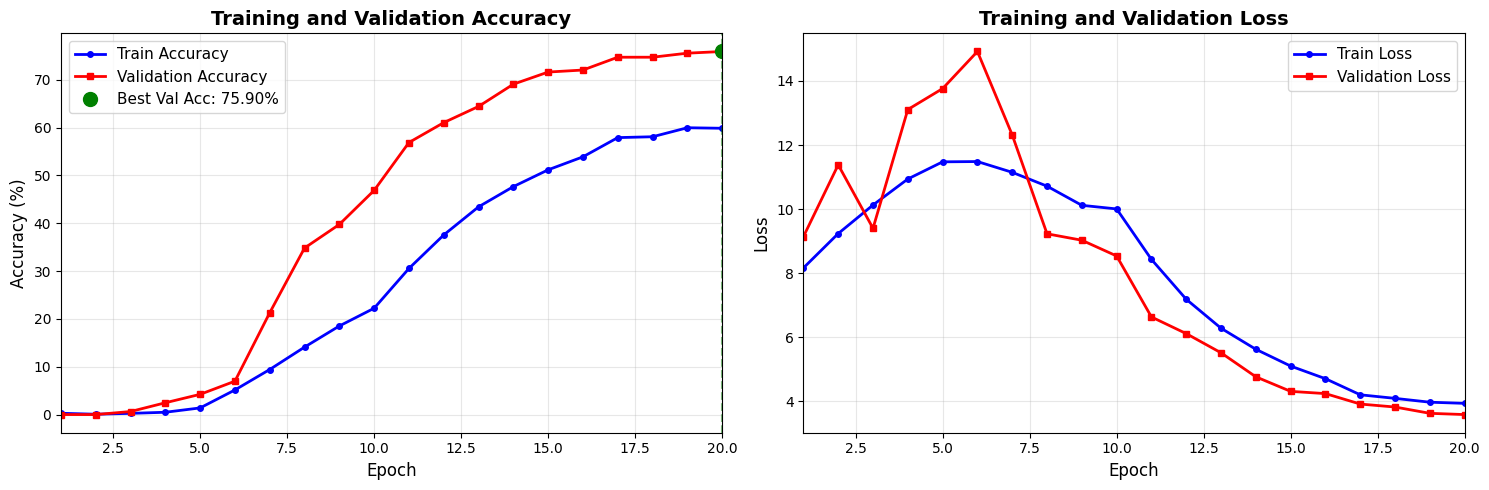

   ✅ Saved training curves to: /kaggle/working/checkpoints/vitro/training_curves.png


In [14]:
print(f"\n🚀 Starting training for {epochs} epochs...")
print(f"   Device: {device}")
print(f"   Learning rate: {lr}")
print(f"   Batch size: {batch_size}\n")

best_val_acc = 0.0

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# ArcFace margin warmup config (nếu cần)
arcface_margin_warmup_epochs = 10  # Số epochs warmup, set 0 để tắt
arcface_margin = 0.30  # Target margin

for epoch in range(epochs):
    use_warmup = (arcface_margin_warmup_epochs > 0 and 
                  model.arcface_head.m.std() < 1e-6)  
    
    if use_warmup:
        if epoch < arcface_margin_warmup_epochs:
            warmup_ratio = (epoch + 1) / arcface_margin_warmup_epochs
            current_margin = arcface_margin * warmup_ratio
            
            model.arcface_head.m.fill_(float(current_margin))
            
            if epoch == 0 or (epoch + 1) % max(1, arcface_margin_warmup_epochs // 3) == 0:
                print(f"   [Warmup] ArcFace margin: {current_margin:.4f} (target: {arcface_margin:.4f})")
        else:
            with torch.no_grad():
                model.arcface_head.m.fill_(float(arcface_margin))

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch, use_amp=False)
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch=epoch, use_amp=False)
    
    scheduler.step()
    
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}\n")
    
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'best_val_acc': best_val_acc,
        'num_classes': num_classes,
        'embedding_size': embedding_size,
    }
    
    torch.save(checkpoint, os.path.join(output_dir, 'latest.pth'))
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint['best_val_acc'] = best_val_acc
        torch.save(checkpoint, os.path.join(output_dir, 'best.pth'))
        print(f"  ✅ Saved best model (val_acc: {val_acc:.2f}%)\n")

print(f"\n📊 Plotting training curves...")
plot_training_curves(
    train_acc_history, val_acc_history,
    train_loss_history, val_loss_history,
    save_path=os.path.join(output_dir, 'training_curves.png')
)
print(f"   ✅ Saved training curves to: {os.path.join(output_dir, 'training_curves.png')}")

In [15]:
print(f"\n{'='*70}")
print("FINAL TEST EVALUATION")
print(f"{'='*70}")

best_checkpoint = torch.load(os.path.join(output_dir, 'best.pth'), map_location=device)
model.load_state_dict(best_checkpoint['model_state_dict'])

test_results = evaluate_test(
    model, test_loader, train_loader, criterion, device
)

best_checkpoint['test_precision_at_1'] = test_results['precision_at_1']
best_checkpoint['test_recall_at_5'] = test_results['recall_at_5']
best_checkpoint['test_mean_average_precision'] = test_results['mean_average_precision']
torch.save(best_checkpoint, os.path.join(output_dir, 'best.pth'))

print(f"\n Training completed!")
print(f"   Best Val Acc: {best_val_acc:.2f}%")
print(f"   Test Precision@1: {test_results['precision_at_1'] * 100:.2f}%")
print(f"   Test Recall@5: {test_results['recall_at_5'] * 100:.2f}%")
print(f"   Test mAP: {test_results['mean_average_precision']:.4f}")
print(f"   Checkpoints saved to: {output_dir}")


FINAL TEST EVALUATION

🧪 Evaluating on TEST set...
   Extracting embeddings...


Extracting:   0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_20/3732664577.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Extracting: 100%|██████████| 156/156 [00:33<00:00,  4.67it/s]


   Computing metrics...

📊 TEST Results:
   1-NN Accuracy (Precision@1): 93.98%
   Recall@5: 96.48%
   Mean Average Precision (mAP): 0.7774

 Training completed!
   Best Val Acc: 75.90%
   Test Precision@1: 93.98%
   Test Recall@5: 96.48%
   Test mAP: 0.7774
   Checkpoints saved to: /kaggle/working/checkpoints/vitro


In [16]:
# # resnet50_vitro = ArcFaceBaseline("resnet50", num_classes).to(device)
# mnv3_vitro     = ArcFaceBaseline("mobilenet_v3_large", num_classes).to(device)

# # best_val_v1, test_v1, state_v1 = run_stage("Vitro", resnet50_vitro, train_loader, val_loader, test_loader, train_loader, device, 20, lr, 1e-4, freeze=True, out_prefix="ResNet50 ")
# best_val_v2, test_v2, state_v2 = run_stage("Vitro", mnv3_vitro,     train_loader, val_loader, test_loader, train_loader, device, 20, lr, 1e-4, freeze=True, out_prefix="MNV3    ")

# # print(f"\n resnet 50")
# # print(f"   Best Val Acc: {best_val_v1:.2f}%")
# # print(f"   Test Precision@1: {test_v1['precision_at_1'] * 100:.2f}%")
# # print(f"   Test Recall@5: {test_v1['recall_at_5'] * 100:.2f}%")
# # print(f"   Test mAP: {test_v1['mean_average_precision']:.4f}")
# # print(f"   Checkpoints saved to: {output_dir}")
# # print("---------------------------------------------------------------------------------------")
# print(f"\n mobilenet v3")
# print(f"   Best Val Acc: {best_val_v2:.2f}%")
# print(f"   Test Precision@1: {test_v2['precision_at_1'] * 100:.2f}%")
# print(f"   Test Recall@5: {test_v2['recall_at_5'] * 100:.2f}%")
# print(f"   Test mAP: {test_v2['mean_average_precision']:.4f}")
# print(f"   Checkpoints saved to: {output_dir}")

In [17]:
data_dir = '/kaggle/input/dataxuly/processing/inSitu/inSitu'  
pretrained_path = '/kaggle/working/checkpoints/vitro/best.pth'  
output_dir = '/kaggle/working/checkpoints/situ'
epochs = 50
batch_size = 64
lr = 0.001
embedding_size = 512
use_color_embedding = True
color_embedding_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_weighted_sampling = False
use_class_weights = True

# Tạo output dir
os.makedirs(output_dir, exist_ok=True)

In [18]:
print("📦 Loading in-situ dataset...")
train_loader, val_loader, test_loader, num_classes, full_dataset = create_data_loaders(
    data_dir, 
    batch_size=batch_size,
    dataset_type='situ',
    use_weighted_sampling=use_weighted_sampling
)

print(f"   Classes: {num_classes}")
print(f"   Train samples: {len(train_loader.dataset)}")
print(f"   Val samples: {len(val_loader.dataset)}")
print(f"   Test samples: {len(test_loader.dataset)}")

📦 Loading in-situ dataset...
   [Situ] Loaded 13121 samples from 120 classes
   [Situ] Loaded 13121 samples from 120 classes
   [Situ] Loaded 13121 samples from 120 classes
   Classes: 120
   Train samples: 9184
   Val samples: 1312
   Test samples: 2625


In [19]:
print("\n🏗️  Creating model...")
inverted_residual_setting, last_channel = res_mobilenet_conf(width_mult=1.0)
model = ResMobileNetV2(
    inverted_residual_setting=inverted_residual_setting,
    embedding_size=embedding_size,
    num_classes=num_classes,
    use_color_embedding=use_color_embedding,
    color_embedding_size=color_embedding_size,
    arcface_s=25,  # Giảm từ 30.0 → 22.5 để margin mềm hơn, model linh hoạt hơn
    dropout_rate=0.45  # Tăng từ 0.3 → 0.45 để giảm overfitting
).to(device)

print(f"\n📂 Loading pretrained checkpoint: {pretrained_path}")
load_pretrained_checkpoint(model, pretrained_path, device, strict=False)

unfreeze_all_layers(model)


🏗️  Creating model...

📂 Loading pretrained checkpoint: /kaggle/working/checkpoints/vitro/best.pth
📂 Loading pretrained checkpoint: /kaggle/working/checkpoints/vitro/best.pth
   ✅ Loaded pretrained weights from epoch 19
   ✅ Pretrained val acc: 75.90%
✅ Unfrozen: All layers (full fine-tuning)


In [20]:
if use_class_weights:
    class_weights = get_class_weights(full_dataset, device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"\n   ✅ Using class weights in loss function")
    print(f"   Weight range: {class_weights.min():.2f} - {class_weights.max():.2f}")
else:
    criterion = nn.CrossEntropyLoss()

stem_params = list(model.conv1.parameters()) + list(model.bn1.parameters()) + \
              list(model.transition.parameters())
mobile_params = list(model.mobile_features.parameters())
tail_params = list(model.res_block.parameters()) + list(model.res_block_2.parameters()) + \
              list(model.res_block_3.parameters()) + list(model.res_block_4.parameters()) 
              # list(model.res_block_5.parameters()) + list(model.res_block_6.parameters())
head_params = list(model.fc_1.parameters()) + list(model.batch_norm_1.parameters()) + \
              list(model.arcface_head.parameters())

optimizer = optim.AdamW([
    {'params': stem_params, 'lr': lr * 0.1},      
    {'params': mobile_params, 'lr': lr * 0.5},
    {'params': tail_params, 'lr': lr},           
    {'params': head_params, 'lr': lr * 2.0}      
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

   Dataset classes: 120, Model classes: 120
   Class weights shape: torch.Size([120])
   Min class_id: 1, Max class_id: 120

   ✅ Using class weights in loss function
   Weight range: 0.13 - 2.19



🚀 Starting fine-tuning for 50 epochs...
   Device: cuda
   Base learning rate: 0.001
   Batch size: 64
   Weighted sampling: False
   Class weights: True



Epoch 0 [Train]:   0%|          | 0/144 [00:00<?, ?it/s]/tmp/ipykernel_20/3732664577.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tmp/ipykernel_20/571843887.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if not torch.isfinite(torch.tensor(grad_norm, device='cpu')): continue



Epoch 1/50:
  Train Loss: 8.6245, Train Acc: 8.36%
  Val Loss: 5.2923, Val Acc: 33.99%
  LR: 0.000100

  ✅ Saved best model (val_acc: 33.99%)




Epoch 2/50:
  Train Loss: 6.4111, Train Acc: 19.57%
  Val Loss: 3.5653, Val Acc: 47.79%
  LR: 0.000100

  ✅ Saved best model (val_acc: 47.79%)




Epoch 3/50:
  Train Loss: 5.2154, Train Acc: 27.68%
  Val Loss: 2.8940, Val Acc: 52.67%
  LR: 0.000099

  ✅ Saved best model (val_acc: 52.67%)




Epoch 4/50:
  Train Loss: 4.4692, Train Acc: 33.06%
  Val Loss: 2.2381, Val Acc: 62.42%
  LR: 0.000098

  ✅ Saved best model (val_acc: 62.42%)




Epoch 5/50:
  Train Loss: 3.9433, Train Acc: 38.85%
  Val Loss: 2.0203, Val Acc: 66.08%
  LR: 0.000098

  ✅ Saved best model (val_acc: 66.08%)




Epoch 6/50:
  Train Loss: 3.5022, Train Acc: 42.89%
  Val Loss: 1.6711, Val Acc: 70.43%
  LR: 0.000096

  ✅ Saved best model (val_acc: 70.43%)




Epoch 7/50:
  Train Loss: 3.1094, Train Acc: 47.90%
  Val Loss: 1.6350, Val Acc: 72.03%
  LR: 0.000095

  ✅ Saved best model (val_acc: 72.03%)




Epoch 8/50:
  Train Loss: 2.8278, Train Acc: 50.97%
  Val Loss: 1.4884, Val Acc: 75.08%
  LR: 0.000094

  ✅ Saved best model (val_acc: 75.08%)




Epoch 9/50:
  Train Loss: 2.6325, Train Acc: 53.57%
  Val Loss: 1.2462, Val Acc: 78.51%
  LR: 0.000092

  ✅ Saved best model (val_acc: 78.51%)




Epoch 10/50:
  Train Loss: 2.4215, Train Acc: 56.39%
  Val Loss: 1.2336, Val Acc: 77.59%
  LR: 0.000090




Epoch 11/50:
  Train Loss: 2.2093, Train Acc: 59.23%
  Val Loss: 1.0100, Val Acc: 79.57%
  LR: 0.000089

  ✅ Saved best model (val_acc: 79.57%)




Epoch 12/50:
  Train Loss: 2.0688, Train Acc: 61.35%
  Val Loss: 1.0183, Val Acc: 81.55%
  LR: 0.000086

  ✅ Saved best model (val_acc: 81.55%)




Epoch 13/50:
  Train Loss: 1.9489, Train Acc: 62.49%
  Val Loss: 1.0123, Val Acc: 82.24%
  LR: 0.000084

  ✅ Saved best model (val_acc: 82.24%)




Epoch 14/50:
  Train Loss: 1.7554, Train Acc: 65.12%
  Val Loss: 1.0005, Val Acc: 83.16%
  LR: 0.000082

  ✅ Saved best model (val_acc: 83.16%)




Epoch 15/50:
  Train Loss: 1.6740, Train Acc: 66.91%
  Val Loss: 0.9179, Val Acc: 84.53%
  LR: 0.000079

  ✅ Saved best model (val_acc: 84.53%)




Epoch 16/50:
  Train Loss: 1.5621, Train Acc: 68.73%
  Val Loss: 0.7901, Val Acc: 85.90%
  LR: 0.000077

  ✅ Saved best model (val_acc: 85.90%)




Epoch 17/50:
  Train Loss: 1.4447, Train Acc: 70.14%
  Val Loss: 0.8059, Val Acc: 85.98%
  LR: 0.000074

  ✅ Saved best model (val_acc: 85.98%)




Epoch 18/50:
  Train Loss: 1.3745, Train Acc: 71.85%
  Val Loss: 0.6488, Val Acc: 88.49%
  LR: 0.000071

  ✅ Saved best model (val_acc: 88.49%)




Epoch 19/50:
  Train Loss: 1.2713, Train Acc: 73.00%
  Val Loss: 0.7009, Val Acc: 89.10%
  LR: 0.000068

  ✅ Saved best model (val_acc: 89.10%)




Epoch 20/50:
  Train Loss: 1.1976, Train Acc: 74.73%
  Val Loss: 0.7012, Val Acc: 88.87%
  LR: 0.000065




Epoch 21/50:
  Train Loss: 1.1556, Train Acc: 75.76%
  Val Loss: 0.6687, Val Acc: 89.02%
  LR: 0.000062




Epoch 22/50:
  Train Loss: 1.0958, Train Acc: 76.03%
  Val Loss: 0.7799, Val Acc: 89.33%
  LR: 0.000059

  ✅ Saved best model (val_acc: 89.33%)




Epoch 23/50:
  Train Loss: 1.0418, Train Acc: 77.55%
  Val Loss: 0.7297, Val Acc: 88.34%
  LR: 0.000056




Epoch 24/50:
  Train Loss: 1.0090, Train Acc: 78.58%
  Val Loss: 0.6477, Val Acc: 90.62%
  LR: 0.000053

  ✅ Saved best model (val_acc: 90.62%)




Epoch 25/50:
  Train Loss: 0.9100, Train Acc: 80.00%
  Val Loss: 0.6014, Val Acc: 91.23%
  LR: 0.000050

  ✅ Saved best model (val_acc: 91.23%)




Epoch 26/50:
  Train Loss: 0.8957, Train Acc: 80.77%
  Val Loss: 0.5597, Val Acc: 90.62%
  LR: 0.000047




Epoch 27/50:
  Train Loss: 0.8171, Train Acc: 81.74%
  Val Loss: 0.5940, Val Acc: 91.08%
  LR: 0.000044




Epoch 28/50:
  Train Loss: 0.7384, Train Acc: 83.46%
  Val Loss: 0.5438, Val Acc: 92.15%
  LR: 0.000041

  ✅ Saved best model (val_acc: 92.15%)




Epoch 29/50:
  Train Loss: 0.7181, Train Acc: 84.28%
  Val Loss: 0.5194, Val Acc: 92.68%
  LR: 0.000038

  ✅ Saved best model (val_acc: 92.68%)




Epoch 30/50:
  Train Loss: 0.7388, Train Acc: 83.60%
  Val Loss: 0.5116, Val Acc: 92.45%
  LR: 0.000035




Epoch 31/50:
  Train Loss: 0.6890, Train Acc: 84.45%
  Val Loss: 0.5162, Val Acc: 92.91%
  LR: 0.000032

  ✅ Saved best model (val_acc: 92.91%)




Epoch 32/50:
  Train Loss: 0.6393, Train Acc: 85.20%
  Val Loss: 0.5331, Val Acc: 92.99%
  LR: 0.000029

  ✅ Saved best model (val_acc: 92.99%)




Epoch 33/50:
  Train Loss: 0.5905, Train Acc: 86.22%
  Val Loss: 0.4686, Val Acc: 93.37%
  LR: 0.000026

  ✅ Saved best model (val_acc: 93.37%)




Epoch 34/50:
  Train Loss: 0.5742, Train Acc: 86.80%
  Val Loss: 0.5228, Val Acc: 93.06%
  LR: 0.000023




Epoch 35/50:
  Train Loss: 0.5340, Train Acc: 87.51%
  Val Loss: 0.5680, Val Acc: 92.07%
  LR: 0.000021




Epoch 36/50:
  Train Loss: 0.5246, Train Acc: 87.63%
  Val Loss: 0.4998, Val Acc: 93.90%
  LR: 0.000018

  ✅ Saved best model (val_acc: 93.90%)




Epoch 37/50:
  Train Loss: 0.5132, Train Acc: 88.25%
  Val Loss: 0.5178, Val Acc: 93.45%
  LR: 0.000016




Epoch 38/50:
  Train Loss: 0.4729, Train Acc: 89.24%
  Val Loss: 0.4940, Val Acc: 94.05%
  LR: 0.000014

  ✅ Saved best model (val_acc: 94.05%)




Epoch 39/50:
  Train Loss: 0.4952, Train Acc: 88.68%
  Val Loss: 0.4681, Val Acc: 94.13%
  LR: 0.000011

  ✅ Saved best model (val_acc: 94.13%)




Epoch 40/50:
  Train Loss: 0.4296, Train Acc: 89.60%
  Val Loss: 0.4917, Val Acc: 93.98%
  LR: 0.000010




Epoch 41/50:
  Train Loss: 0.4573, Train Acc: 89.33%
  Val Loss: 0.4731, Val Acc: 94.36%
  LR: 0.000008

  ✅ Saved best model (val_acc: 94.36%)




Epoch 42/50:
  Train Loss: 0.4581, Train Acc: 89.26%
  Val Loss: 0.4848, Val Acc: 94.21%
  LR: 0.000006




Epoch 43/50:
  Train Loss: 0.4204, Train Acc: 90.18%
  Val Loss: 0.4631, Val Acc: 94.28%
  LR: 0.000005




Epoch 44/50:
  Train Loss: 0.4161, Train Acc: 89.90%
  Val Loss: 0.4657, Val Acc: 94.21%
  LR: 0.000004




Epoch 45/50:
  Train Loss: 0.4058, Train Acc: 89.88%
  Val Loss: 0.4590, Val Acc: 94.21%
  LR: 0.000002




Epoch 46/50:
  Train Loss: 0.4002, Train Acc: 90.43%
  Val Loss: 0.4576, Val Acc: 94.36%
  LR: 0.000002




Epoch 47/50:
  Train Loss: 0.3890, Train Acc: 90.53%
  Val Loss: 0.4639, Val Acc: 94.36%
  LR: 0.000001




Epoch 48/50:
  Train Loss: 0.4111, Train Acc: 90.36%
  Val Loss: 0.4616, Val Acc: 94.44%
  LR: 0.000000

  ✅ Saved best model (val_acc: 94.44%)




Epoch 49/50:
  Train Loss: 0.4004, Train Acc: 91.00%
  Val Loss: 0.4607, Val Acc: 94.28%
  LR: 0.000000




Epoch 50/50:
  Train Loss: 0.4062, Train Acc: 90.09%
  Val Loss: 0.4610, Val Acc: 94.21%
  LR: 0.000000


📊 Plotting training curves...
   📈 Training curves plotted successfully
   👁️  Đang hiển thị biểu đồ...


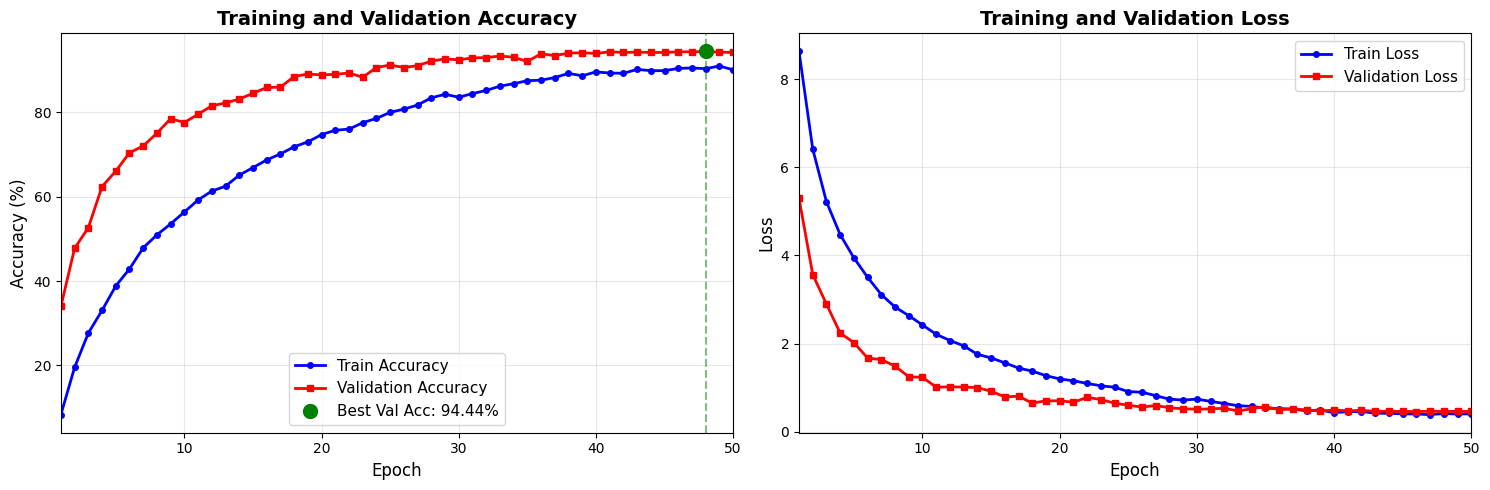

   ✅ Saved training curves to: /kaggle/working/checkpoints/situ/training_curves_situ.png


In [21]:
print(f"\n🚀 Starting fine-tuning for {epochs} epochs...")
print(f"   Device: {device}")
print(f"   Base learning rate: {lr}")
print(f"   Batch size: {batch_size}")
print(f"   Weighted sampling: {use_weighted_sampling}")
print(f"   Class weights: {use_class_weights}\n")

best_val_acc = 0.0

# ✨ THÊM: Lưu history để plot biểu đồ
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Scheduler step
    scheduler.step()
    
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}\n")
    
    # ✨ THÊM: Lưu vào history
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'best_val_acc': best_val_acc,
        'num_classes': num_classes,
        'embedding_size': embedding_size,
        'pretrained_from': pretrained_path,
    }
    
    # Save latest
    torch.save(checkpoint, os.path.join(output_dir, 'latest.pth'))
    
    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint['best_val_acc'] = best_val_acc
        torch.save(checkpoint, os.path.join(output_dir, 'best.pth'))
        print(f"  ✅ Saved best model (val_acc: {val_acc:.2f}%)\n")

# ✨ THÊM: Plot biểu đồ sau khi training xong
print(f"\n📊 Plotting training curves...")
plot_training_curves(
    train_acc_history, val_acc_history,
    train_loss_history, val_loss_history,
    save_path=os.path.join(output_dir, 'training_curves_situ.png')
)
print(f"   ✅ Saved training curves to: {os.path.join(output_dir, 'training_curves_situ.png')}")

In [22]:
print(f"\n{'='*70}")
print("FINAL TEST EVALUATION")
print(f"{'='*70}")

best_checkpoint = torch.load(os.path.join(output_dir, 'best.pth'), map_location=device)
model.load_state_dict(best_checkpoint['model_state_dict'])

test_results = evaluate_test(
    model, test_loader, train_loader, criterion, device
)

best_checkpoint['test_precision_at_1'] = test_results['precision_at_1']
best_checkpoint['test_recall_at_5'] = test_results['recall_at_5']
best_checkpoint['test_mean_average_precision'] = test_results['mean_average_precision']
torch.save(best_checkpoint, os.path.join(output_dir, 'best.pth'))

print(f"\n Fine-tuning completed!")
print(f"   Best Val Acc: {best_val_acc:.2f}%")
print(f"   Test Precision@1: {test_results['precision_at_1'] * 100:.2f}%")
print(f"   Test Recall@5: {test_results['recall_at_5'] * 100:.2f}%")
print(f"   Test mAP: {test_results['mean_average_precision']:.4f}")
print(f"   Checkpoints saved to: {output_dir}")


FINAL TEST EVALUATION

🧪 Evaluating on TEST set...
   Extracting embeddings...


Extracting:   0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipykernel_20/3732664577.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Extracting: 100%|██████████| 144/144 [00:49<00:00,  2.91it/s]


   Computing metrics...

📊 TEST Results:
   1-NN Accuracy (Precision@1): 97.49%
   Recall@5: 98.51%
   Mean Average Precision (mAP): 0.9560

 Fine-tuning completed!
   Best Val Acc: 94.44%
   Test Precision@1: 97.49%
   Test Recall@5: 98.51%
   Test mAP: 0.9560
   Checkpoints saved to: /kaggle/working/checkpoints/situ


In [23]:
!zip -r situ_model.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/vitro/ (stored 0%)
  adding: kaggle/working/checkpoints/vitro/latest.pth (deflated 16%)
  adding: kaggle/working/checkpoints/vitro/best.pth (deflated 16%)
  adding: kaggle/working/checkpoints/situ/ (stored 0%)
  adding: kaggle/working/checkpoints/situ/latest.pth (deflated 24%)
  adding: kaggle/working/checkpoints/situ/best.pth (deflated 24%)
  adding: kaggle/working/__notebook__.ipynb (deflated 92%)


In [24]:
!ls /kaggle/working

checkpoints  __notebook__.ipynb  situ_model.zip


In [25]:
from IPython.display import HTML, display

display(HTML("""
<a href="situ_model.zip" download 
   style="font-size:20px;color:blue;font-weight:bold">
👉 CLICK ĐỂ TẢI MODEL 👈
</a>
"""))